In [ ]:
import os
import time
from copy import deepcopy

import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import networkx as nx
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from scipy import sparse
from scipy.sparse.linalg.eigen.arpack import eigsh

# Utils

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ind.citeseer.allx to ind.citeseer.allx
Saving ind.citeseer.ally to ind.citeseer.ally
Saving ind.citeseer.graph to ind.citeseer.graph
Saving ind.citeseer.test.index to ind.citeseer.test.index
Saving ind.citeseer.tx to ind.citeseer.tx
Saving ind.citeseer.ty to ind.citeseer.ty
Saving ind.citeseer.x to ind.citeseer.x
Saving ind.citeseer.y to ind.citeseer.y
Saving ind.cora.allx to ind.cora.allx
Saving ind.cora.ally to ind.cora.ally
Saving ind.cora.graph to ind.cora.graph
Saving ind.cora.test.index to ind.cora.test.index
Saving ind.cora.tx to ind.cora.tx
Saving ind.cora.ty to ind.cora.ty
Saving ind.cora.x to ind.cora.x
Saving ind.cora.y to ind.cora.y
Saving ind.pubmed.allx to ind.pubmed.allx
Saving ind.pubmed.ally to ind.pubmed.ally
Saving ind.pubmed.graph to ind.pubmed.graph
Saving ind.pubmed.test.index to ind.pubmed.test.index
Saving ind.pubmed.tx to ind.pubmed.tx
Saving ind.pubmed.ty to ind.pubmed.ty
Saving ind.pubmed.x to ind.pubmed.x
Saving ind.pubmed.y to ind.pubmed.y


In [ ]:
PATH = "gcn.pth"
def get_onehot(labels):
  s = pd.Series(labels)
  df = pd.get_dummies(s)
  return df.to_numpy()

def normalise(mat):
  """mat gets row-normalized"""
  row_sum = np.array(mat.sum(1))
  reciprocal = np.reciprocal(row_sum).flatten()
  reciprocal[np.isinf(reciprocal)] = 0
  reciprocal_mat = sparse.diags(reciprocal)
  return reciprocal_mat.dot(mat)

def get_sparse_tensor(mat):
  mat = mat.tocoo().astype(np.float32)
  indices = T.from_numpy(
      np.vstack((mat.row, mat.col)).astype(np.int64)
  )
  values = T.from_numpy(mat.data)
  return T.sparse.FloatTensor(indices, values, T.Size(mat.shape))


# FEAT TO X
def load_data(dataset="cora"):
  data = []
  for suffix in ['x', 'y', 'allx', 'ally', 'tx', 'ty', 'graph']:
        
    path = 'ind.{}.{}'.format(dataset, suffix)
    data.append(pickle.load(open(path, 'rb'), encoding='latin1'))

  x, y, allx, ally, tx, ty, graph = data
  # test indices
  test_path = 'ind.{}.test.index'.format(dataset)
  with open(test_path, 'r') as f:
      lines = f.readlines()
  indices = [int(line.strip()) for line in lines]
  test_idx_range = np.sort(indices)
  min_index, max_index = min(test_idx_range), max(test_idx_range)

  if dataset == "citeseer":
    test_idx_range_full = range(min_index, max_index+1)
    tx_extended = sparse.lil_matrix((len(test_idx_range_full), x.shape[1]))
    tx_extended[test_idx_range-min(test_idx_range), :] = tx
    tx = tx_extended
    ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
    ty_extended[test_idx_range-min(test_idx_range), :] = ty
    ty = ty_extended
  
  features = sparse.vstack((allx, tx)).tolil()
  features[indices, :] = features[test_idx_range, :]
  features = T.from_numpy(normalise(features.todense()))

  labels = np.vstack((ally, ty))
  labels[indices, :] = labels[test_idx_range, :]



  # x, allx, tx = x.toarray(), allx.toarray(), tx.toarray()




  
  # preprocess test indices and combine all data
  # tx_extend = np.zeros((max_index - min_index + 1, tx.shape[1]))
  # features = np.vstack([allx, tx_extend])
  # features[indices] = tx
  # ty_extend = np.zeros((max_index - min_index + 1, ty.shape[1]))
  # labels = np.vstack([ally, ty_extend])
  # labels[indices] = ty

  # get edge list
  edges = nx.from_dict_of_lists(graph).edges
  E = []
  for e in edges:
    E.append([e[0], e[1]])
  E = np.array(E)

  A = sparse.coo_matrix(
    (np.ones(E.shape[0]), (E[:, 0], E[:, 1])),
    (len(labels), len(labels)),
    np.float32
  )
  A = A + A.T.multiply(A.T > A) - A.multiply(A < A.T)
  A = normalise(A + sparse.eye(A.shape[0]))
  A = get_sparse_tensor(A)

  train_indices = T.tensor(range(len(y)))
  val_indices = T.tensor(range(len(y), len(y) + 500))
  test_indices = T.tensor(indices)

  labels = T.tensor(np.nonzero(labels)[1])
  

  for data in [A, features, labels, train_indices, val_indices, test_indices]:
    yield data.cuda()

# Layers

In [ ]:
class GraphConvolution(nn.Module):
  """
  Graph convolutional network layer
  """
  def __init__(self, input_dims, out_dims):
    super().__init__()
    self.input_dims = input_dims
    self.out_dims = out_dims
    self.weight = Parameter(T.Tensor(input_dims, out_dims))
    self.bias = Parameter(T.Tensor(out_dims))
    self.init_weights()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def init_weights(self):
    nn.init.xavier_uniform_(self.weight)
    nn.init.zeros_(self.bias)

  def forward(self, inp, adj):
    sup = T.mm(inp.double(), self.weight.double())
    out = T.spmm(adj.double(), sup.double())
    return out + self.bias

# Models

In [ ]:
class GCN(nn.Module):
  """
  Graph Convolutional Network 
  """
  def __init__(self, n_features, n_hidden, n_classes, p, n_layers=2):
    super().__init__()
    self.stack = nn.ModuleList()
    self.gc1 = GraphConvolution(n_features, n_hidden)
    self.gc = GraphConvolution(n_hidden, n_hidden)
    self.gc2 = GraphConvolution(n_hidden, n_classes)
    self.drop1 = nn.Dropout(p=p)

    self.stack.append(self.gc1)
    for _ in range(n_layers-2):
      self.stack.append(self.gc)
    self.stack.append(self.gc2)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)



  def forward(self, x, A):
    for layer in self.stack[:-1]:
      x = F.relu(layer(x, A))
      x = self.drop1(x)
    x = self.stack[-1](x, A)


    return F.log_softmax(x, 1)


# Train

In [ ]:
args_dict = {
    'no_cuda': False,
    'fastmode': False,
    'seed': 42,
    'epochs': 200,
    'learning_rate': 0.01,
    'weight_decay': 5e-4,
    'hidden': 16,
    'dropout': 0.5,
    'cuda': True
}

class Args:
    __slots__ = list(args_dict.keys())
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args = Args(**args_dict)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)


def train(dataset="cora", verbose=True):

  t_total = time.time()
  for epoch in range(args.epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    out = model(X, A)
    train_loss = F.nll_loss(
        out[train_indices], labels[train_indices]
    )
    train_acc =  T.Tensor.float(out[train_indices].max(1)[1].type_as(labels[train_indices]) == labels[train_indices]).mean()
    train_loss.backward()
    optimizer.step()

    model.eval()
    out = model(X, A)
    val_loss = F.nll_loss(
        out[val_indices], labels[val_indices]
    )
    val_acc =  T.Tensor.float(out[val_indices].max(1)[1].type_as(labels[val_indices]) == labels[val_indices]).mean()
    if verbose:
      print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss.item()),
              'acc_train: {:.4f}'.format(train_acc.item()),
              'loss_val: {:.4f}'.format(val_loss.item()),
              'acc_val: {:.4f}'.format(val_acc.item()),
              'time: {:.4f}s'.format(time.time() - t))
    torch.save(model.state_dict(), dataset+PATH)
    
  return train_acc.item(), val_acc.item()

def test(dataset="cora", verbose=True):
  A, X, labels, train_indices, val_indices, test_indices = load_data(dataset)
  model.eval()
  out = model(X, A)
  test_loss = F.nll_loss(
      out[test_indices], labels[test_indices]
  )
  test_acc =  T.Tensor.float(out[test_indices].max(1)[1].type_as(labels[test_indices]) == labels[test_indices]).mean()
  if verbose:
    print("Test set results:",
            "loss= {:.4f}".format(test_loss.item()),
            "accuracy= {:.4f}".format(test_acc.item()))
  return test_acc.item()

In [ ]:
dataset = "cora"
A, X, labels, train_indices, val_indices, test_indices = load_data(dataset)
model = GCN(
    X.shape[1], #why
    args.hidden,
    labels.max().item()+1,
    args.dropout
)

optimizer = optim.Adam(
    model.parameters(),
    args.learning_rate,
    weight_decay=args.weight_decay
)

train(dataset, verbose=False)
# Testing
test(dataset)

Test set results: loss= 0.7176 accuracy= 0.8030


0.8030000329017639

In [ ]:
dataset = "pubmed"
A, X, labels, train_indices, val_indices, test_indices = load_data(dataset)
model = GCN(
    X.shape[1], #why
    args.hidden,
    labels.max().item()+1,
    args.dropout
)

optimizer = optim.Adam(
    model.parameters(),
    args.learning_rate,
    weight_decay=args.weight_decay
)

train(dataset, verbose=False)
# Testing
test(dataset)

Test set results: loss= 0.5529 accuracy= 0.7840


0.784000039100647

# t-SNE Visualisation

In [ ]:
def plot_tsne(dataset="cora", saved=False):
  layer_out = []
  def hook_func(module, input, output):
      layer_out.append(output.detach().cpu().numpy())
  A, X, labels, train_indices, val_indices, test_indices = load_data(dataset)

  model = GCN(
      X.shape[1], #why
      args.hidden,
      labels.max().item()+1,
      args.dropout
  )
  gcn_layer1 = model.gc1
  gcn_layer1.register_forward_hook(hook_func)
  if saved:  model.load_state_dict(torch.load(dataset+PATH))
  model.eval()
  model(X, A)

  x_all = layer_out[0]
  y_train = labels.cpu().numpy()
  tsne = TSNE(n_components = 2, random_state=0, init= 'pca', learning_rate='auto')
  x_train = x_all.reshape(x_all.shape[0],-1)
  tsne_res = tsne.fit_transform(x_train)
  sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_train, palette = sns.hls_palette(labels.max().item() + 1), legend = False);
  if saved: plt.title(str(args.epochs))
  else: plt.title("Epoch 0")
  
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


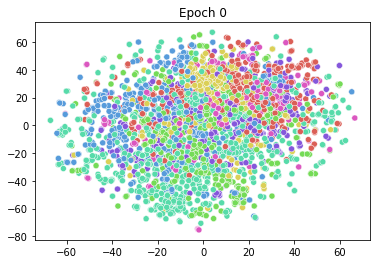

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


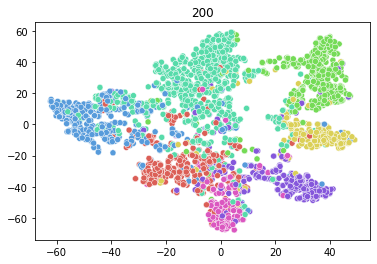

In [ ]:
plot_tsne(dataset="cora", saved=False)
plot_tsne(dataset="cora", saved=True);

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


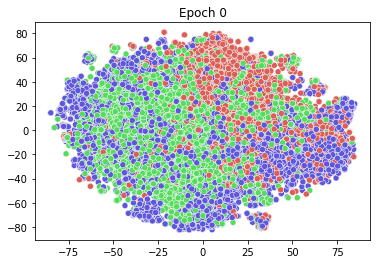

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


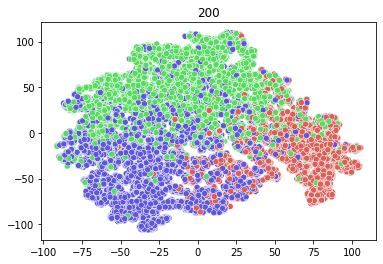

In [ ]:
plot_tsne(dataset="pubmed", saved=False)
plot_tsne(dataset="pubmed", saved=True);

# Model Depth

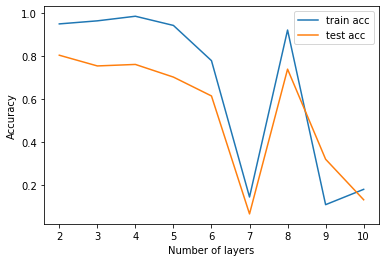

In [ ]:
acc_list = []
dataset='cora'
A, X, labels, train_indices, val_indices, test_indices = load_data(dataset)
for layer in range(2, 11):
  model = GCN(
      X.shape[1], #why
      args.hidden,
      labels.max().item()+1,
      args.dropout,
      layer
  )
  optimizer = optim.Adam(
    model.parameters(),
    args.learning_rate,
    weight_decay=args.weight_decay
  )
  acc_next = [0]*2
  acc_next[0], _ =train(dataset, verbose=False)
  # Testing
  acc_next[1] = test(dataset,verbose=False)
  acc_list.append(acc_next)


acc_list = np.array(acc_list)
plt.xticks(range(9), labels=range(2, 11))
plt.plot(acc_list[:, 0], label="train acc")
plt.plot(acc_list[:, 1], label="test acc")
plt.xlabel("Number of layers")
plt.ylabel("Accuracy")
plt.legend()

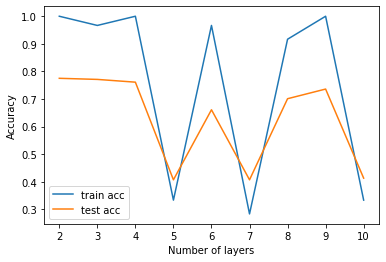

In [ ]:
acc_list = []
dataset='pubmed'
A, X, labels, train_indices, val_indices, test_indices = load_data(dataset)
for layer in range(2, 11):
  model = GCN(
      X.shape[1], #why
      args.hidden,
      labels.max().item()+1,
      args.dropout,
      layer
  )
  optimizer = optim.Adam(
    model.parameters(),
    args.learning_rate,
    weight_decay=args.weight_decay
  )
  acc_next = [0]*2
  acc_next[0], _ =train(dataset, verbose=False)
  # Testing
  acc_next[1] = test(dataset,verbose=False)
  acc_list.append(acc_next)


acc_list = np.array(acc_list)
plt.xticks(range(9), labels=range(2, 11))
plt.plot(acc_list[:, 0], label="train acc")
plt.plot(acc_list[:, 1], label="test acc")
plt.xlabel("Number of layers")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
# def train(epochs, dataset="cora", verbose=True):
#     t_total = time.time()
#     for epoch in range(epochs):
#       t = time.time()
#       model.train()
#       optimizer.zero_grad()
#       out = model(X, A)
#       train_loss = F.nll_loss(
#           out[train_indices], labels[train_indices]
#       )
#       train_acc =  T.Tensor.float(out[train_indices].max(1)[1].type_as(labels[train_indices]) == labels[train_indices]).mean()
#       train_loss.backward()
#       optimizer.step()

#       model.eval()
#       out = model(X, A)
#       val_loss = F.nll_loss(
#           out[val_indices], labels[val_indices]
#       )
#       val_acc =  T.Tensor.float(out[val_indices].max(1)[1].type_as(labels[val_indices]) == labels[val_indices]).mean()
#       if verbose:
#         print('Epoch: {:04d}'.format(epoch+1),
#                 'loss_train: {:.4f}'.format(train_loss.item()),
#                 'acc_train: {:.4f}'.format(train_acc.item()),
#                 'loss_val: {:.4f}'.format(val_loss.item()),
#                 'acc_val: {:.4f}'.format(val_acc.item()),
#                 'time: {:.4f}s'.format(time.time() - t))
#       torch.save(model.state_dict(), dataset+PATH)
      
#     return train_acc.item(), val_acc.item()

# for epoch in range(10, 200, 25):
#   for dataset in ["cora", "pubmed"]:
#     train(epoch, dataset, verbose=False)


# def plot_tsne(epoch,  dataset="cora",saved=False):
#   layer_out = []
#   def hook_func(module, input, output):
#       layer_out.append(output.detach().cpu().numpy())
#   A, X, labels, train_indices, val_indices, test_indices = load_data(dataset)

#   model = GCN(
#       X.shape[1], #why
#       args.hidden,
#       labels.max().item()+1,
#       args.dropout
#   )
#   gcn_layer1 = model.gc1
#   gcn_layer1.register_forward_hook(hook_func)
#   if saved:  model.load_state_dict(torch.load(dataset+PATH))
#   model.eval()
#   model(X, A)

#   x_all = layer_out[0]
#   y_train = labels.cpu().numpy()
#   tsne = TSNE(n_components = 2, random_state=0, init= 'pca', learning_rate='auto')
#   x_train = x_all.reshape(x_all.shape[0],-1)
#   tsne_res = tsne.fit_transform(x_train)
#   sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_train, palette = sns.hls_palette(labels.max().item() + 1), legend = False);
#   if saved: plt.title("Epoch " + str(epoch))
#   else: plt.title("Epoch 0")
  
#   plt.savefig(str(epoch)+"-"+dataset + ".png")


# plot_tsne(epoch,  dataset="cora",saved=False)
# plot_tsne(epoch,  dataset="pubmed",saved=False)

# for epoch in range(10, 200, 25):
#   for dataset in ["cora", "pubmed"]:
#     plot_tsne(epoch,  dataset="cora",saved=True)

In [ ]:
 plot_tsne(50,  dataset="cora",saved=True)

TypeError: plot_tsne() got multiple values for argument 'dataset'